## Computer generation of fruit shapes from DNA sequence: Image to image

### Citation:
M. Pérez-Enciso, C. Pons, A. Graell, A.J. Monforte, L.M. Zingaretti. Computer generation of fruit shapes from DNA sequence. Biorxiv. [submitted](https://www.biorxiv.org/content/10.1101/2022.09.19.508595v1)

mperezenciso@gmail.com

Requires from preparation script
- TraditomImgset.pkl (~1Gb), which is available from dropbox link https://www.dropbox.com/s/hvmt1a2qursameq/TraditomImgset.pkl?dl=0

In [24]:
# check library version numbers 
import numpy as np
print('numpy: %s' % np.__version__) 
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)
import random
import seaborn as sns
import skimage
import scipy
import plotly
import PIL
from PIL import Image, ImageDraw, ImageFilter
import cv2
print('opencv: %s' % cv2.__version__)
print('PIL: %s' % PIL.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

numpy: 1.22.4
matplotlib: 3.4.3
opencv: 4.5.1
PIL: 8.3.2


In [25]:
# DL modules
# tensorflow
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)
# keras
from tensorflow import keras
print('keras: %s' % keras.__version__)
from tensorflow.keras import layers
import kerastuner as kt
print('kerastuner: %s' % kt.__version__)
from tensorflow.python.keras import backend as K

tensorflow: 2.4.1
keras: 2.4.0
kerastuner: 1.0.2


## Input is image pair of ellipses
### Autoencoder - like architecture

In [26]:
# decoder network dna --> image: generates images out of image pairs
def img22img(image_size, embed_size=2):
    input1 = keras.Input(shape=image_size+(1,))
    input2 = keras.Input(shape=image_size+(1,))
    x1 = layers.experimental.preprocessing.Rescaling(1.0 / 255)(input1)
    x2 = layers.experimental.preprocessing.Rescaling(1.0 / 255)(input2)

    x = layers.Concatenate()([x1, x2])
    x = keras.layers.Conv2D(16, (5,5), activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x)
    x = keras.layers.Flatten()(x)                                 
    x = keras.layers.Dense(16)(x)
    
    embed = keras.layers.Dense(embed_size)(x)

    x = keras.layers.Dense(np.prod(image_size))(embed)
    x = keras.layers.Reshape(image_size+(1,))(x)
    x = keras.layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2DTranspose(8, (3,3), activation='relu', padding='same')(x)
 
    output = keras.layers.Conv2DTranspose(1, (5,5), activation='relu', padding='same')(x)

    return keras.Model(inputs=[input1, input2], outputs=output)

In [27]:
# draw a continuum given radius / axis with some stochasticity
def draw_shaper(size, shape):
    axis, radius = shape
    #radius = np.random.randint(4,size//2)
    #axis = np.random.randint(4,size//2)
    img = np.zeros((size,size,1), np.uint8)
    center = (size//2,size//2)
    cv2.ellipse(img,center,(axis,radius),0,0,360,1,-1)
    area = np.count_nonzero(img)/(size*size)
    return img, area


In [28]:
# generates offspring images according to several inheritance patterns
def do_offspring(shape1, shape2, action='add'):
    if action in 'additivity':
        shape = ((shape1 + shape2)*0.5).astype(int)
    elif action in 'imprinting':
        shape = shape1
    elif action in 'dominance':
        shape = np.array(list(max(x) for x in zip(shape1,shape2)))
    elif action in 'epistasis':
        shape = ((shape1 + shape2)*0.5).astype(int)
        shape = [shape[1], shape[0]]
    return shape

In [29]:
# some parameters
n_train = 1000
n_test = 100
size = 64
image_size = (size, size)

In [30]:
# generate parent pairs and offspring
a = 'imp'
shapes1=[]  # axis, radius
shapes2=[]  # axis, radius
imgs1=[]
imgs2=[]
imgs12=[]

for _ in range(n_train+n_test):
    s1 = np.random.randint(3,size//2, size=2)
    img,_ = draw_shaper(size,shape=s1)
    shapes1.append(s1)
    imgs1.append(img)
    s2 = np.random.randint(3,size//2, size=2)
    img,_ = draw_shaper(size,shape=s2)
    shapes2.append(s2)
    imgs2.append(img)
    shape = do_offspring(s1, s2, action=a)
    img,_ = draw_shaper(size,shape=shape)
    imgs12.append(img)

imgs1, imgs2, imgs12 = np.array(imgs1), np.array(imgs2), np.array(imgs12)
shapes1, shapes2 = np.array(shapes1), np.array(shapes2)

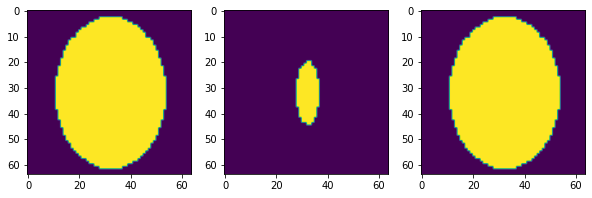

In [31]:
i = np.random.randint(n_train)
plt.figure(figsize=(10, 5))
ax = plt.subplot(1,3, 1)
plt.imshow(imgs1[i])
ax = plt.subplot(1,3, 2)
plt.imshow(imgs2[i])
ax = plt.subplot(1,3, 3)
plt.imshow(imgs12[i])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 64, 64, 1)    0           input_2[0][0]                    
______________________________________________________________________________________________

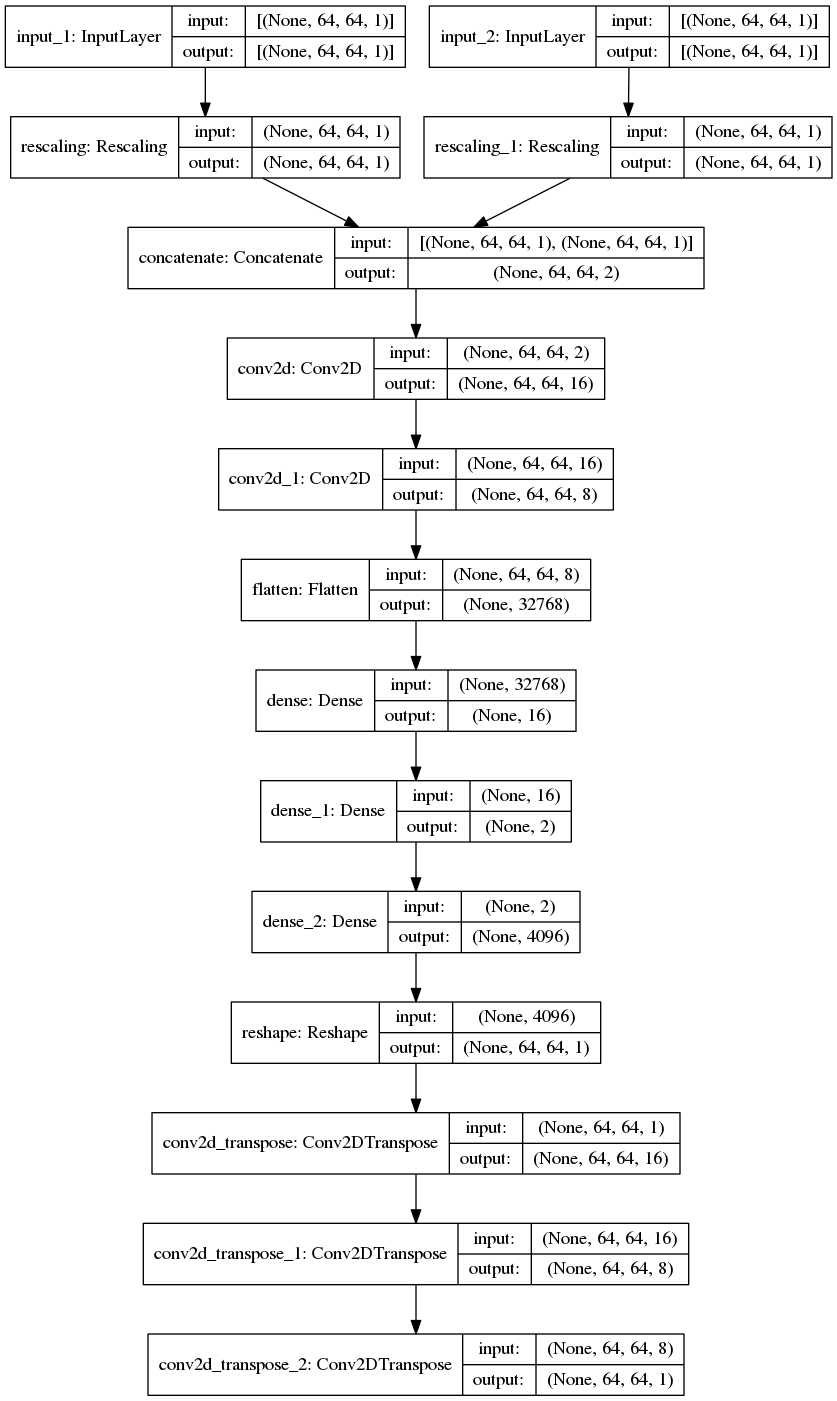

In [32]:
if 'autoencoder_img' in locals() or 'autoencoder_img' in globals(): del autoencoder_img

autoencoder_img = img22img(image_size, embed_size=2)

autoencoder_img.compile(optimizer='adam',
                loss=keras.losses.MeanSquaredError(),
                metrics=keras.metrics.MeanSquaredError(), )

autoencoder_img.summary()

keras.utils.plot_model(autoencoder_img, show_shapes=True)


In [ ]:
epochs = 10

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

autoencoder_img.fit(x=[imgs1, imgs2],
          y=imgs12,
          epochs=epochs, 
          batch_size=64, 
          callbacks=callbacks, )

In [ ]:
i = np.random.randint(n_train)
plt.figure(figsize=(10, 5))
ax = plt.subplot(1,4, 1)
plt.imshow(imgs1[i])
ax = plt.subplot(1,4, 2)
plt.imshow(imgs2[i])
ax = plt.subplot(1,4, 3)
plt.imshow(imgs12[i])
ax = plt.subplot(1,4, 4)
img1 = tf.expand_dims(imgs1[i], 0)
img2 = tf.expand_dims(imgs2[i], 0)
img = autoencoder_img.predict([img1,img2]).reshape(image_size)
plt.imshow(img)


## Tomato inheritance

In [40]:
# read img trios
# TraditomImgset.pkl is available from dropbox link: 
#    https://www.dropbox.com/s/hvmt1a2qursameq/TraditomImgset.pkl?dl=0
imgset = pickle.load(open('data/TraditomImgset.pkl', 'rb'))

# generate img arrays
imgset = np.array(imgset)

# partition
imgset_train, imgset_test = train_test_split(imgset, test_size=0.1)

# paternal, maternal and offspring
imgs1, imgs2, imgs12 = imgset_train[:,0], imgset_train[:,1], imgset_train[:,2]
image_size = imgs1.shape[1:]
image_size

(128, 128)

In [34]:
imgset_train.shape

(2092, 3, 128, 128)

In [41]:
if 'ae22' in locals() or 'ae22' in globals(): del ae22

ae22 = img22img(image_size, embed_size=8)

ae22.compile(optimizer='adam',
             loss=keras.losses.MeanSquaredError(),
             metrics=keras.metrics.MeanSquaredError(), )

In [42]:
epochs = 50

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=5),]

ae22.fit(x=[imgs1, imgs2],
         y=imgs12,
         epochs=epochs, 
         batch_size=16, 
         callbacks=callbacks, 
         validation_split=0.1, )

Epoch 1/50
131/131 [==============================] - 38s 283ms/step - loss: 4470.4143 - mean_squared_error: 4470.4143
Epoch 2/50
131/131 [==============================] - 37s 280ms/step - loss: 1624.1941 - mean_squared_error: 1624.1941
Epoch 3/50
131/131 [==============================] - 36s 271ms/step - loss: 1079.7389 - mean_squared_error: 1079.7389
Epoch 4/50
131/131 [==============================] - 35s 264ms/step - loss: 971.1578 - mean_squared_error: 971.1578
Epoch 5/50
131/131 [==============================] - 36s 274ms/step - loss: 946.4452 - mean_squared_error: 946.4452
Epoch 6/50
131/131 [==============================] - 40s 307ms/step - loss: 869.5363 - mean_squared_error: 869.5363
Epoch 7/50
131/131 [==============================] - 38s 289ms/step - loss: 879.1925 - mean_squared_error: 879.1925
Epoch 8/50
131/131 [==============================] - 38s 292ms/step - loss: 832.1272 - mean_squared_error: 832.1272
Epoch 9/50
131/131 [==============================] - 38s 

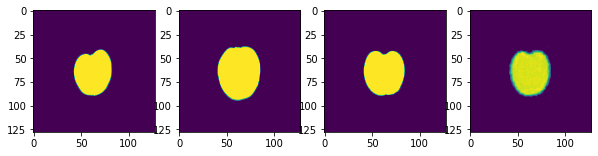

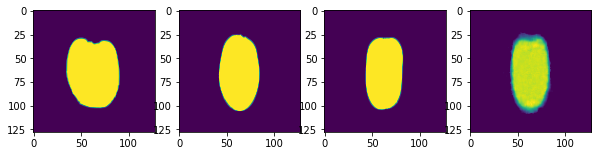

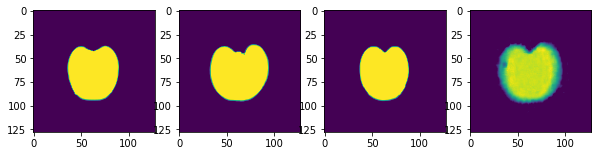

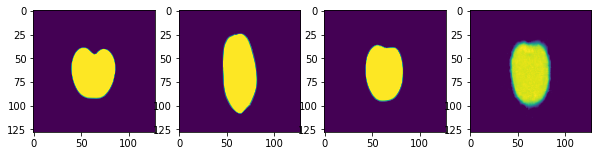

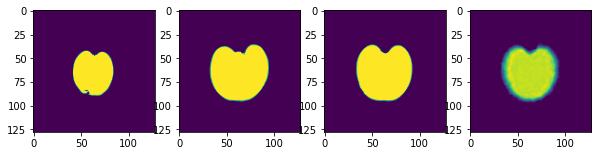

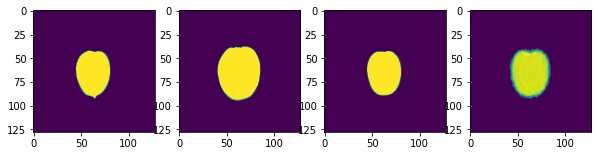

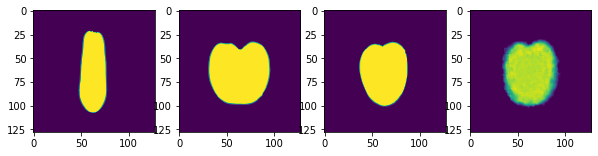

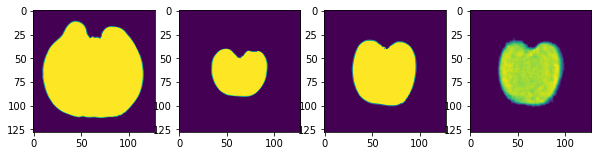

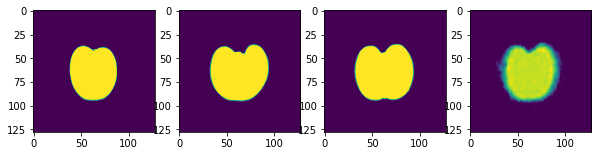

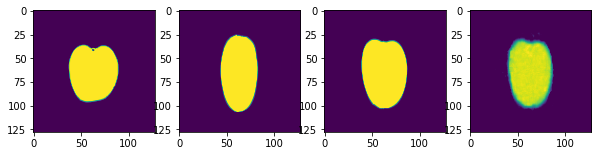

In [44]:
# some test
for _ in range(10):
    i = np.random.randint(len(imgset_test))
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(1,4, 1)
    plt.imshow(imgset_test[i,0])
    ax = plt.subplot(1,4, 2)
    plt.imshow(imgset_test[i,1])
    ax = plt.subplot(1,4, 3)
    plt.imshow(imgset_test[i,2])
    ax = plt.subplot(1,4, 4)
    img1 = tf.expand_dims(imgset_test[i,0], 0)
    img2 = tf.expand_dims(imgset_test[i,1], 0)
    img = ae22.predict([img1,img2]).reshape(image_size)
    plt.imshow(img)
    #print(i)
